# Univariate sensitivity analysis using pre-saved model outputs
#### Brandon Chan | November 25th 2021
Examples of conducting sensitivity analysis using previously saved model outputs as a starting point. This notebook covers two simple cases:
<ol>
    <li> Sensitivity analysis to varying costs of treatment </li>
    <li> Sensitivity analysis to varying probabilities of remaining in the remission state </li>
</ol>

## Import packages

In [1]:
import numpy as np # Scientific computing - used for n-dimensional arrays, numerical functions
import math
from scipy import stats
from scipy.stats import bootstrap
import pandas as pd # Dataframe structure and reading of excel files
import matplotlib.pyplot as plt # Plotting package
import seaborn as sns # Another plotting package
import os # for file path things
import plotly.express as px
import sys
sys.path.insert(0,"../src") # Direct to the src directory depending on where you're developing from
from markov_modeling import *

np.random.seed(123)

## Load in previously saved specifications and corresponding model outputs
We look at a simple state model that was previously used as an example in the cost-effectivness analysis notebook. The three states being: 1) treatment; 2) remission; and 3) death

<b> Note: </b> These outputs may or may not be the same as the ones included in the repository by default. Please adjust filenames if needed, or adjust to the outputof an example you've run yourself!

In [2]:
specification_base = ModelSpec('../model_specifications/test_parameters_base.xlsx', 
                               model_name='test_base')
specification_treat = ModelSpec('../model_specifications/test_parameters_treat.xlsx',
                                model_name='test_treat')

pop_base = np.load('../model_outputs/test_base_24-11-2021_population.npy')
cost_base = np.load('../model_outputs/test_base_24-11-2021_costs.npy')
util_base = np.load('../model_outputs/test_base_24-11-2021_utilities.npy')

pop_treat = np.load('../model_outputs/test_treat_24-11-2021_population.npy')
cost_treat = np.load('../model_outputs/test_treat_24-11-2021_costs.npy')
util_treat = np.load('../model_outputs/test_treat_24-11-2021_utilities.npy')
                    
outputs_base = ModelData(pop_base, cost_base, util_base)
outputs_treat = ModelData(pop_treat, cost_treat, util_treat)                    

## 1) Sensitivity analysis by adjusting cost for a particular state
In this example we look at modifying/adjusting the cost of treatment in the treatment arm. Note: This assumes the same movement of the cohort for each analysis but will regenerate the cost outputs based on differing costs-per-state. Could be adjusted to perform sensitivity analysis on utility as well.

#### 1.1) Define a helper function that will assist in applying a new constant/static cost to a targeted state and return a modified cost array output

In [3]:
def apply_constant_cost(pop_array, cost_array, specification, target_state, new_cost):
    '''
    Function that will modify costs in a cost array for a single state by applying a constant cost.
    
    Input: pop_array = [num_iterations x num_states x num_cycles] shpaed numpy array representing
                       model output with respect to population movement
           cost_array = [num_iterations x num_states x num_cycles] shaped numpy array representing
                        model output with respect to cost accured by the population at each state, 
                        iteration, and cycle
           specification = instance of ModelSpec object with loaded specification
           target_state = string denoting the corresponding state name to alter costs. Maps to 
                          state_mappings dictionary in the ModelSpec
           new_cost = float or int denoting the new constant cost you wish the state to take
    Output: cost_array_modified = [num_iterations x num_states x num_cycles] shaped numpy array representing
                                   model output with respect to cost accured by the population at each state, 
                                   iteration, and cycle, modified based on target_state and new_cost input args.
    '''
    cost_array_modified = cost_array.copy()   
    
    # Identify numeric index of target state based on state_mapping in model specification
    idx = specification.state_mapping[target_state]
    
    # Apply new cost to all iterations and cycles for the target state index
    cost_array_modified[:, idx, :] = pop_array[:, idx, :] * new_cost 

    # Apply discount rate if applicable
    for i in range(0,cost_array_modified.shape[2]):
        year = math.floor((i*specification.cycle_length)/365)
        cost_array_modified[:,idx,i] = cost_array_modified[:,idx,i] * (1 / ((1+specification.discount_rate)**year))
  
    return cost_array_modified

#### 1.2) Use the apply_constant_cost() function to generate model outputs over a range of treatment costs

In [4]:
# Set parameters of costs we'd like to apply
lower_bound = 200 
upper_cost_bound = 600
step = 10

# Initialize empty dataframes for logging results
cost_analysis_df = pd.DataFrame({'new_applied_cost':[], 'ICER':[], 'delta_mean_cost':[], 'delta_mean_util':[]})
cost_analysis_iteration_data_df = pd.DataFrame({'new_applied_cost':[], 'delta_cost':[], 'delta_util':[]})

# Compute delta mean utility. Since this an analysis on costs, the delta utility remains constant despite changes
delta_mean_utility = np.mean(outputs_treat.iteration_util_data) - np.mean(outputs_base.iteration_util_data)

for new_applied_cost in range(lower_bound, upper_cost_bound+1, step):
    # Apply new cost by modifying cost array & simplify to a new per-iteration cost array
    new_cost_treat = apply_constant_cost(pop_treat, cost_treat, specification_treat, 'treatment', new_applied_cost)
    new_cycle_cost_treat = np.sum(new_cost_treat, axis=1)
    new_iteration_costs_treat = np.sum(new_cycle_cost_treat, axis=1)

    # Recaulculate delta mean costs for iteration
    delta_mean_cost = np.mean(new_iteration_costs_treat) - np.mean(outputs_base.iteration_cost_data)
    
    # Calculate ICER
    ICER = delta_mean_cost/delta_mean_utility
    
    # Log measures
    cost_analysis_df = pd.concat([cost_analysis_df, pd.DataFrame({'new_applied_cost':[new_applied_cost], 'ICER':[ICER], 
                                                                  'delta_mean_cost':[delta_mean_cost], 
                                                                  'delta_mean_util':[delta_mean_utility]})])
    
    
    # Compute per-iteration comparisons for costs and utilities and log (i.e. results you'd see on the CE plane)
    c = new_iteration_costs_treat - outputs_base.iteration_cost_data
    u = outputs_treat.iteration_util_data - outputs_base.iteration_util_data
    cost_analysis_iteration_data_df = pd.concat([cost_analysis_iteration_data_df,
                                                 pd.DataFrame({'new_applied_cost':[new_applied_cost]*pop_treat.shape[0], 
                                                                'delta_cost':c, 
                                                                'delta_util':u})])

cost_analysis_df = cost_analysis_df.reset_index(drop=True)
cost_analysis_iteration_data_df = cost_analysis_iteration_data_df.reset_index(drop=True)

lambda_threshold = 1000
cost_analysis_df['nmb'] = cost_analysis_df.apply(lambda x: lambda_threshold * x.delta_mean_util - x.delta_mean_cost, axis=1)

#### 1.3) Looking at variation in ICER and NMB

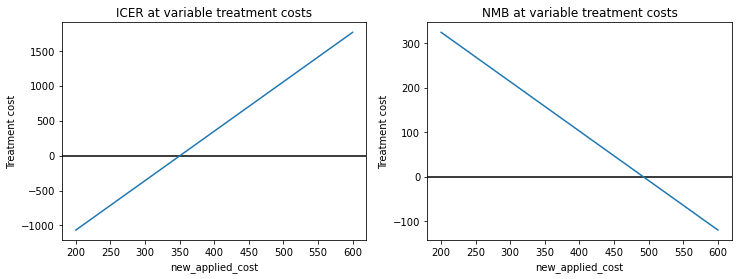

In [5]:
fig, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].axhline(0, color='black')
ax[1].axhline(0, color='black')
ax[0].set_title('ICER at variable treatment costs')
ax[1].set_title('NMB at variable treatment costs')
ax[0].set_ylabel('Treatment cost')
ax[1].set_ylabel('Treatment cost')
sns.lineplot(data=cost_analysis_df, x="new_applied_cost", y="ICER", ax=ax[0])
sns.lineplot(data=cost_analysis_df, x="new_applied_cost", y="nmb", ax=ax[1])
plt.show()

#### 1.4) Looking at how the CE plane shifts

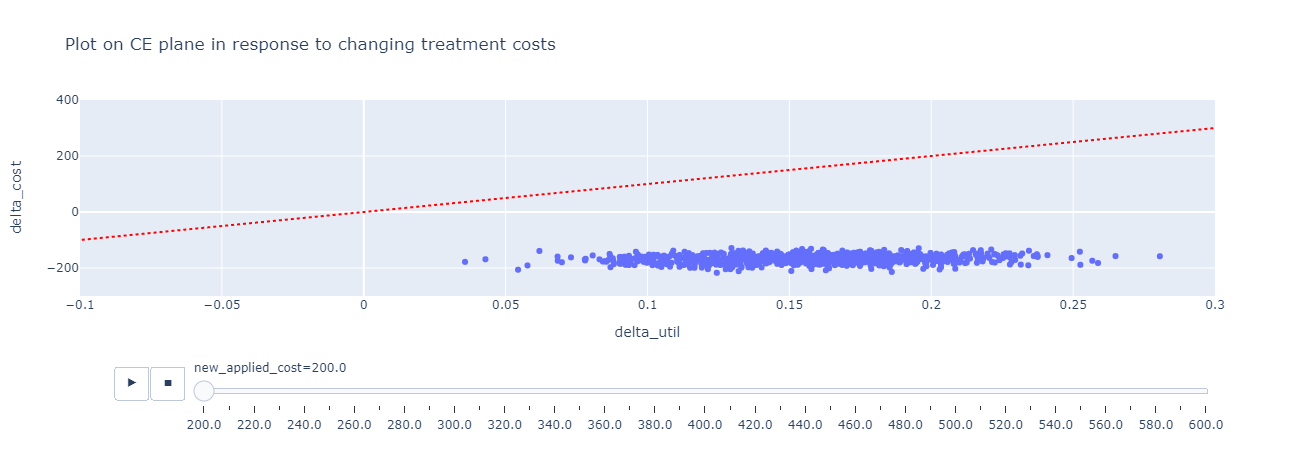

In [6]:
fig = px.scatter(cost_analysis_iteration_data_df, x="delta_util", y="delta_cost", animation_frame="new_applied_cost", 
           range_y=[-300,400], range_x=[-0.1,0.3], title='Plot on CE plane in response to changing treatment costs')

fig.add_shape(type="line",
              x0=-1, y0=-1000, x1=1, y1=1000,
              line=dict(color="red",
                        width=2,
                        dash="dot"))
fig.show()

## 2) Sensitivity analysis through adjusting transition probabilities
In this example we look at modifying the transition probability of staying in the remission state vs entering the death state. Adapting this to different models may be trickier by virtue of needing to account for additional outbound probabilities if there are more than 2 and also the need to pre-identify relevant rows in your specification spreadsheet to target specific transitions of interest.

<b> Note: </b> This is more computationally expensive as it involves re-runing the model multiple times to generate a new population output. Furthermore, technically costs and utilities need to be resampled and recalculated for each sensitivity analysis (if there are probabilistic costs and/or utilities). Compared to the methodology in the previous example, this can be different on a conceptual level.

#### 2.1) Iterate a range of static probabilities and rerun/log model output for each scenario

In [7]:
# Define upper and lower bounds of the sensitivity analysis
lower_bound = 30 # out of 100%
upper_bound = 90 # out of 100%
step = 10

# Re-load the specification of the treatment arm as a new variable/copy that we will modify on the fly
new_specification = ModelSpec('../model_specifications/test_parameters_treat.xlsx',
                                model_name='test_treat')

# Initialize empty dataframes for logging results
transiton_analysis_df = pd.DataFrame({'new_probability_r2r':[], 'ICER':[], 'delta_mean_cost':[], 'delta_mean_util':[]})
transiton_analysis_iteration_data_df = pd.DataFrame({'new_probability_r2r':[], 'delta_cost':[], 'delta_util':[]})

for probability in range(lower_bound, upper_bound+1, step):
    # Scale to a decimal representation
    probability_scaled = probability/100
    
    # Modifying row index 3 (technically row 4) which is the remission -> remission transition
    new_specification.structure.loc[3, 'type'] = 'constant'
    new_specification.structure.loc[3, 'parameter_1'] = probability_scaled
    new_specification.structure.loc[3, 'parameter_2'] = np.nan
    
    # Modifying row index 5 (technically row 5) which is the remission -> death transition to be the remainder 
    # (i.e. 1-probability). Could technically use redisual as well, or leave it alone if it was previously defined as a residual 
    new_specification.structure.loc[4, 'type'] = 'constant'
    new_specification.structure.loc[4, 'parameter_1'] = 1 - probability_scaled
    new_specification.structure.loc[4, 'parameter_2'] = np.nan
    
    # Recalculate primary model outputs
    new_pop_array = run_model(new_specification)
    new_cost_array = calculate_costs(new_pop_array, new_specification)
    new_util_array = calculate_utilities(new_pop_array, new_specification)
    
    new_outputs_treat = ModelData(new_pop_array, new_cost_array, new_util_array) 
    
    # Derive and log model outputs of interest
    delta_mean_cost = np.mean(new_outputs_treat.iteration_cost_data) - np.mean(outputs_base.iteration_cost_data)
    delta_mean_utility = np.mean(new_outputs_treat.iteration_util_data) - np.mean(outputs_base.iteration_util_data)

    ICER = delta_mean_cost/delta_mean_utility
    
    transiton_analysis_df = pd.concat([transiton_analysis_df, pd.DataFrame({'new_probability_r2r':[probability_scaled], 'ICER':[ICER], 
                                                                  'delta_mean_cost':[delta_mean_cost], 
                                                                  'delta_mean_util':[delta_mean_utility]})])
    
    c = new_outputs_treat.iteration_cost_data - outputs_base.iteration_cost_data
    u = new_outputs_treat.iteration_util_data - outputs_base.iteration_util_data
    
    transiton_analysis_iteration_data_df = pd.concat([transiton_analysis_iteration_data_df,
                                                      pd.DataFrame({'new_probability_r2r':[probability_scaled]*pop_treat.shape[0], 
                                                                    'delta_cost':c, 
                                                                    'delta_util':u})])

transiton_analysis_df = transiton_analysis_df.reset_index(drop=True)
transiton_analysis_iteration_data_df = transiton_analysis_iteration_data_df.reset_index(drop=True)

lambda_threshold = 1000
transiton_analysis_df['nmb'] = transiton_analysis_df.apply(lambda x: lambda_threshold * x.delta_mean_util - x.delta_mean_cost, axis=1)

beginning iterations...
model done...
total time: 0.16 seconds || mean time per iteration: 0.0 seconds
beginning iterations...
model done...
total time: 0.18 seconds || mean time per iteration: 0.0 seconds
beginning iterations...
model done...
total time: 0.16 seconds || mean time per iteration: 0.0 seconds
beginning iterations...
model done...
total time: 0.18 seconds || mean time per iteration: 0.0 seconds
beginning iterations...
model done...
total time: 0.16 seconds || mean time per iteration: 0.0 seconds
beginning iterations...
model done...
total time: 0.18 seconds || mean time per iteration: 0.0 seconds
beginning iterations...
model done...
total time: 0.17 seconds || mean time per iteration: 0.0 seconds


#### 2.2) Plot out ICERs and NMBs in relation to changing probability of staying in remission

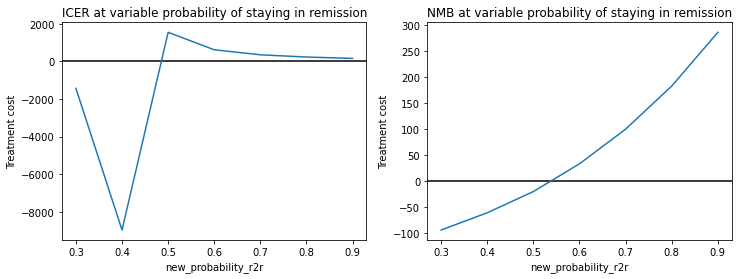

In [8]:
fig, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].axhline(0, color='black')
ax[1].axhline(0, color='black')
ax[0].set_title('ICER at variable probability of staying in remission')
ax[1].set_title('NMB at variable probability of staying in remission')
ax[0].set_ylabel('Treatment cost')
ax[1].set_ylabel('Treatment cost')
sns.lineplot(data=transiton_analysis_df, x="new_probability_r2r", y="ICER", ax=ax[0])
sns.lineplot(data=transiton_analysis_df, x="new_probability_r2r", y="nmb", ax=ax[1])
plt.show()

#### 2.3) Plot out CE plane in relation to changing probability of staying in remission

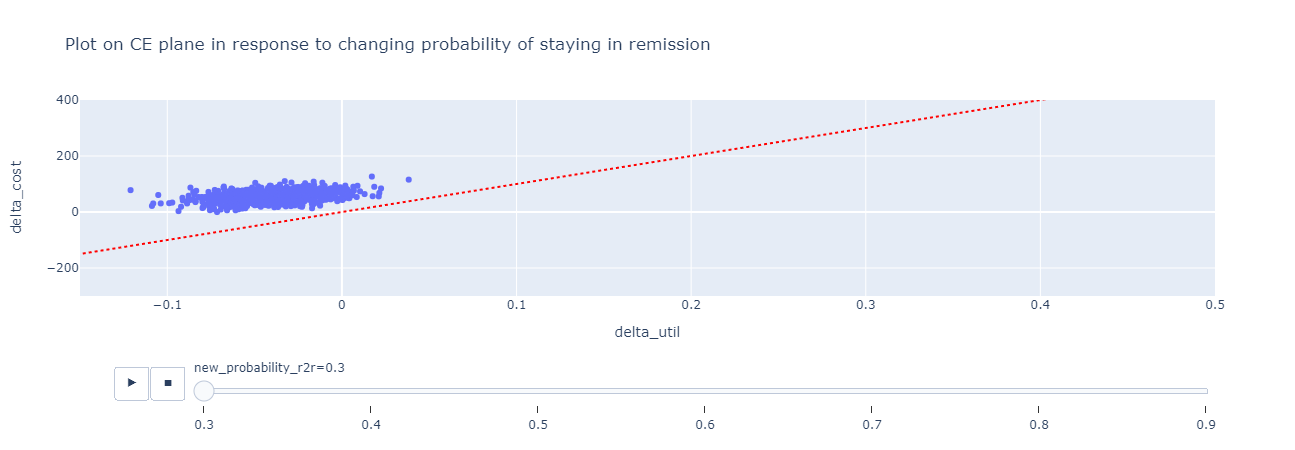

In [9]:
fig = px.scatter(transiton_analysis_iteration_data_df, x="delta_util", y="delta_cost", animation_frame="new_probability_r2r", 
           range_y=[-300,400], range_x=[-0.15,0.5], title='Plot on CE plane in response to changing probability of staying in remission')

fig.add_shape(type="line",
              x0=-1, y0=-1000, x1=1, y1=1000,
              line=dict(color="red",
                        width=2,
                        dash="dot"))
fig.show()